# Human-in-the-Loop AI Defect Classification: Training
Building and tuning the ConvNet.

In [1]:
import tensorflow as tf
print(tf.__version__)

1.8.0


In [2]:
import numpy as np
print(np.__version__)

1.16.2


In [3]:
import os
import re
import pickle
import gc

import pandas as pd
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from PIL import Image

from keras import regularizers, optimizers 
from keras import backend as K

from keras.backend.tensorflow_backend import set_session, clear_session, get_session
from keras.callbacks import Callback
from keras.layers import (Flatten, Activation, Dense, Dropout, BatchNormalization,
                          Conv2D, MaxPooling2D)
from keras.models import Sequential, load_model

from keras_preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.callbacks import *
from CLR.clr_callback import *

%matplotlib inline

TESTFILES_PATH = os.path.join(os.getcwd(), '..', 'testing_files')
CONFIG_PATH = os.path.join(TESTFILES_PATH, 'conf.ini')
DATA_PATH = os.path.join(os.getcwd(), '..', 'raw_data')
OUTPUT_PATH = os.path.join(os.getcwd(), '..', 'cleaned_data')
LOT_ROOT = os.path.join('..', 'raw_data', 'l0Q119TeOS12PostHF')

Using TensorFlow backend.


Running on separate tensorflow kernel for gpu support. If reproducing code in this notebook and need gpu support on backend, be sure to have:
* Visual Studio 2015 (NOT 2017, 2019, etc)
* CUDA v9.0
* CuDNN v7 for CUDA 9.0
* CuDNN dll, lib, and header files are added to CUDA location appropriately
* Add CUDA's libnvvp\, bin\, and x64\ added to your PATH
* Tensorflow v12 (v13 needs to be built from source for CUDA support)

Making sure GPU is enabled (NVIDIA QUADRO M1200 gives ~3x training performance improvement over Intel Core i7-7820 @ 2.90GHZ CPU training)

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12419124385320579480
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3233474150
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2320881285894677922
physical_device_desc: "device: 0, name: Quadro M1200, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [6]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

Utility for preventing tensorflow from using all of my GPU's mem...

In [7]:
def reset_keras(semnet_instance):
    K.clear_session()

    sess = tf.Session()

    K.set_session(sess)
    try:
        del semnet_instance.model
    except:
        pass

    print(gc.collect())

Loading in train/test sets and benchmark model.

In [8]:
train_df = pd.read_csv(os.path.join(TESTFILES_PATH, 'train-HD.csv'))
test_df = pd.read_csv(os.path.join(TESTFILES_PATH, 'test-HD.csv'))
# benchmark_model = load_model(os.path.join(TESTFILES_PATH, 'benchmark.h5'))
# with open(os.path.join(TESTFILES_PATH, 'benchmark_history.pkl'), 'rb') as fh:
#     benchmark_history = pickle.load(fh)

## Benchmark Analysis 

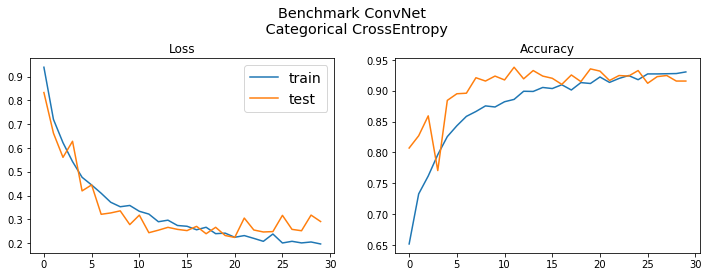

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(benchmark_history['loss'], label='train')
ax1.plot(benchmark_history['val_loss'], label='test')
ax1.set_title('Loss')
ax1.legend(prop={'size':'14'})

ax2.plot(benchmark_history['acc'], label='train')
ax2.plot(benchmark_history['val_acc'], label='test')
ax2.set_title('Accuracy')

plt.suptitle('Benchmark ConvNet \n Categorical CrossEntropy', size='x-large')
plt.subplots_adjust(top=0.8)
plt.show()

### Model Analysis
* Optimization converges ~20 iterations, then starts to overfit
* Need to try a few different optimizers
* Once optimizer is chosen, need to optimize learning rate

### Parameters to tweak:
* Batch Size (going to keep at 32)
* Weight decay
* Optimizer
    * RMSProp
    * SGD
    * ADAM
    * CLR?
* Input shape?
    * Maybe try 500x500, 1000x1000?

### Architecture tweaks?
* Flatten step (1024??)
* Final dropout
* 32x2, 64x2, 128x2, 256x2, 1024 Flat?


In [9]:
class SEMNet:
    """
    Class for building ConvNet for SEM review
    """

    def __init__(self, train_df, test_df):
        self.train_df = train_df
        self.test_df = test_df
        self.data_generator = self._build_data_generator()
        self.model = None
        self.train_generator = None
        self.valid_generator = None
        self.test_generator = None

        
    def _check_model_build(self):
        if not self.model:
            raise AttributeError("Model hasn't been built yet. Run build_model() first")

            
    def _check_generator_build(self):
        if not self.model:
            raise AttributeError("Flow generators haven't been built yet. Run build_flow_generators() first")

            
    @staticmethod
    def _build_data_generator():
        datagen = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True,
                                     validation_split=0.25)
        return datagen

    
    @staticmethod
    def _get_smote_weights(df, target_col='defect_type'):
        """
        Returns dictionary to be passed to class_weight parameter
        in `fit_generator`
        """
        targets = df[target_col]
        classes = targets.unique()
        weights = class_weight.compute_class_weight('balanced', classes=classes, y=targets)    


    def build_flow_generators(self, batch_size=32, target_size=(250, 250), 
                              seed=42):
        """
        Returns tuple of train, validation data flow generators
        """
        train_generator = self.data_generator.flow_from_dataframe(dataframe=self.train_df, directory=None,
                                                      x_col='image_paths', y_col='defect_type', 
                                                      color_mode='grayscale', subset='training', 
                                                      batch_size=batch_size, seed=seed, shuffle=True,
                                                      class_mode='categorical', target_size=target_size, 
                                                     )

        valid_generator = self.data_generator.flow_from_dataframe(dataframe=self.train_df, directory=None,
                                                      x_col='image_paths', y_col='defect_type', 
                                                      color_mode='grayscale', subset='validation', 
                                                      batch_size=batch_size, seed=seed, shuffle=True,
                                                      class_mode='categorical', target_size=target_size, 
                                                     )

        self.train_generator = train_generator
        self.valid_generator = valid_generator


    def build_model(self, input_shape=(250, 250, 1), padding='same', kernel_size=(3, 3),
                    dropout=0.25, final_dropout=0.5, pool_size=(2, 2),
                    optimizer=optimizers.rmsprop(lr=0.0001, decay=1e-6)):
        
        self.model = Sequential()

        # 32 filters (convolution => relu activation) => pooling layer
        self.model.add(Conv2D(32, kernel_size, padding=padding, input_shape=(250, 250, 1)))
        self.model.add(Activation('relu'))
        self.model.add(Conv2D(32, kernel_size))
        self.model.add(Activation('relu'))
        self.model.add(MaxPooling2D(pool_size=pool_size))
        self.model.add(Dropout(dropout))

        # 64 filters (convolution => relu activation) x2 => pooling layer
        self.model.add(Conv2D(64, kernel_size, padding=padding))
        self.model.add(Activation('relu'))
        self.model.add(Conv2D(64, kernel_size))
        self.model.add(Activation('relu'))
        self.model.add(MaxPooling2D(pool_size=pool_size))
        self.model.add(Dropout(dropout))

        # 128 filters (convolution => relu activation) x2 => pooling layer
        self.model.add(Conv2D(128, kernel_size, padding=padding))
        self.model.add(Activation('relu'))
        self.model.add(Conv2D(128, kernel_size))
        self.model.add(Activation('relu'))
        self.model.add(MaxPooling2D(pool_size=pool_size))
        self.model.add(Dropout(dropout))

        # 256 filters (convolution => relu activation) x2 => pooling layer
        self.model.add(Conv2D(256, kernel_size, padding=padding))
        self.model.add(Activation('relu'))
        self.model.add(Conv2D(256, kernel_size))
        self.model.add(Activation('relu'))
        self.model.add(MaxPooling2D(pool_size=pool_size))
        self.model.add(Dropout(dropout))

        # # FC => RELU layers
        self.model.add(Flatten())
        self.model.add(Dense(512)) 
        self.model.add(Activation('relu'))
        self.model.add(Dropout(final_dropout))
        self.model.add(Dense(4, activation='softmax'))
        self.model.compile(optimizer,
                      loss='categorical_crossentropy',
                  metrics=['accuracy'])

        
    def fit(self, epochs, callbacks=None, balance_classes=True):
        step_size_train = self.train_generator.n//self.train_generator.batch_size
        step_size_valid = self.valid_generator.n//self.valid_generator.batch_size
        weights = None
        if balance_classes:
            weights = self._get_smote_weights(self.train_df)
        
        self._check_model_build()
        self.model.fit_generator(generator=self.train_generator,
                                 steps_per_epoch=step_size_train,
                                 validation_data=self.valid_generator,
                                 validation_steps=step_size_valid,
                                 epochs=epochs, class_weight=weights,
                                 callbacks=callbacks)

### SEMNet API:
1. Instantiate a SEMNet object, passing train_df and test_df
    * dfs need `defect_type` and `image_paths` columns
2. Run `.build_flow_generators()` method
3. Run `.build_model()` method

## Crossval Optimizer

Running with default hyperparams...

In [9]:
optim_screen = SEMNet(train_df, test_df)
optim_screen.build_flow_generators()
# optim_screen.build_model(optimizer=optimizers.Adam())
# optim_screen.fit(epochs=10)

C:\Users\MCopeland155816\AppData\Local\Continuum\anaconda3\envs\tf_env\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:269: UserWarning: Found 22 invalid image filename(s) in x_col="image_paths". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 3453 validated image filenames belonging to 4 classes.
Found 1150 validated image filenames belonging to 4 classes.


TODO: Add these functions to the SEMNet class...

In [9]:
# model_smote.save(os.path.join(TESTFILES_PATH, 'benchmark.h5'))

# history = model_smote.history.history
def save_history(semnet_instance, filename):
    """
    pickles history of SEMNet instance
    
    
    input: 
        SEMNet instance
        filename: str (no extension)
    """
    history = semnet_instance.model.history.history
    file = filename + '.pkl'
    with open(os.path.join(TESTFILES_PATH, file), 'wb') as fh:
        pickle.dump(history, fh)

def save_model(semnet_instance, filename):
    """
    pickles history of SEMNet instance
    
    
    input: 
        SEMNet instance
        filename: str (no extension)
    """
    file = filename + '.h5'
    semnet_instance.model.save(os.path.join(TESTFILES_PATH, file))

In [25]:
save_history(adam_optim, 'adam-bl_history')
save_model(adam_optim, 'adam-bl_model')

In [12]:
reset_keras(optim_screen)

optim_screen.build_model(optimizer=optimizers.SGD())
optim_screen.fit(epochs=15)

Found 3473 validated image filenames belonging to 4 classes.
Found 1157 validated image filenames belonging to 4 classes.
Epoch 1/15
108/108 [==============================] - 989s 9s/step - loss: 0.9889 - acc: 0.6193 - val_loss: 0.8629 - val_acc: 0.7474
Epoch 2/15
108/108 [==============================] - 1058s 10s/step - loss: 0.7996 - acc: 0.6975 - val_loss: 0.8457 - val_acc: 0.7991
Epoch 3/15
108/108 [==============================] - 1050s 10s/step - loss: 0.7544 - acc: 0.7236 - val_loss: 0.7839 - val_acc: 0.8222
Epoch 4/15
108/108 [==============================] - 1082s 10s/step - loss: 0.7051 - acc: 0.7366 - val_loss: 0.7310 - val_acc: 0.8107
Epoch 5/15
108/108 [==============================] - 1090s 10s/step - loss: 0.6927 - acc: 0.7348 - val_loss: 0.7803 - val_acc: 0.8480
Epoch 6/15
108/108 [==============================] - 1120s 10s/step - loss: 0.6729 - acc: 0.7437 - val_loss: 0.6650 - val_acc: 0.8258
Epoch 7/15
108/108 [==============================] - 1042s 10s/step -

In [26]:
save_history(adam_optim, 'sgd-bl_history')
save_model(adam_optim, 'sgd-bl_model')

In [10]:
# reset_keras(optim_screen)

optim_screen.build_model(optimizer=optimizers.RMSprop())
optim_screen.fit(epochs=10)

Epoch 1/10
107/107 [==============================] - 101s 944ms/step - loss: 6.4577 - acc: 0.5943 - val_loss: 6.0011 - val_acc: 0.6277
Epoch 2/10
107/107 [==============================] - 98s 916ms/step - loss: 6.4832 - acc: 0.5978 - val_loss: 5.9830 - val_acc: 0.6288
Epoch 3/10
107/107 [==============================] - 93s 873ms/step - loss: 6.4832 - acc: 0.5978 - val_loss: 6.0551 - val_acc: 0.6243
Epoch 4/10
107/107 [==============================] - 101s 946ms/step - loss: 6.4965 - acc: 0.5969 - val_loss: 5.9686 - val_acc: 0.6297
Epoch 5/10
107/107 [==============================] - 92s 856ms/step - loss: 6.4946 - acc: 0.5971 - val_loss: 6.0983 - val_acc: 0.6216
Epoch 6/10
107/107 [==============================] - 93s 874ms/step - loss: 6.5124 - acc: 0.5960 - val_loss: 5.9109 - val_acc: 0.6333
Epoch 7/10
107/107 [==============================] - 92s 863ms/step - loss: 6.5609 - acc: 0.5929 - val_loss: 5.9398 - val_acc: 0.6315
Epoch 8/10
107/107 [==============================] -

In [ ]:
reset_keras(optim_screen)

* ADAM: Converges quickly (~10-15 epochs, 90% val acc)
* SGD: Slower convengence
* RMS: Doesn't converge
Moving to ADAM optimizer. 

# Hyperparameter Optimization 

## Learning Rate Optimization
* Using Adam optimizer
* Cyclical Learning Rate (Smith et al 2015) 

### LR Range Test 
Running just one epoch to see accuracy against learning rate.

stepsize = iterations (batch of 32 is step size of 108)
Running one epoch with stepsize of iterations per epoch (108), which will linearly increase the learning rate, lending insight to relationship between learning rate and performance (accuracy).

### Adam Optimizer 

In [10]:
lr_optim = SEMNet(train_df, test_df)
lr_optim.build_flow_generators(batch_size=32)
# lr_optim.build_model(optimizer=optimizers.Adam())

C:\Users\MCopeland155816\AppData\Local\Continuum\anaconda3\envs\tf_env\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:269: UserWarning: Found 22 invalid image filename(s) in x_col="image_paths". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 3453 validated image filenames belonging to 4 classes.
Found 1150 validated image filenames belonging to 4 classes.


In [15]:
step_size = 108

lr_range_test = CyclicLR(mode='triangular', base_lr=0.001, max_lr=1.0,
                          step_size=step_size)

lr_optim.fit(epochs=1, callbacks=[lr_range_test])

Epoch 1/1
108/108 [==============================] - 969s 9s/step - loss: 1.1868 - acc: 0.5742 - val_loss: 1.0332 - val_acc: 0.6354


In [18]:
# with open(os.path.join(TESTFILES_PATH, 'lr_range_test-adam.pkl'), 'wb') as fh:
#     pickle.dump(lr_range_test.history, fh)

### Stochastic Gradient Descent 

In [21]:
reset_keras(lr_optim)
lr_optim.build_model(optimizer=optimizers.SGD())

clr_triangular= CyclicLR(mode='triangular', base_lr=0.001, max_lr=1.0,
                          step_size=step_size)

lr_optim.fit(epochs=1, callbacks=[clr_triangular])

Epoch 1/1
108/108 [==============================] - 1063s 10s/step - loss: 1.1496 - acc: 0.5869 - val_loss: 1.0181 - val_acc: 0.6354


In [22]:
# with open(os.path.join(TESTFILES_PATH, 'lr_range_test-sgd.pkl'), 'wb') as fh:
#     pickle.dump(clr_triangular.history, fh)

In [50]:
sgd_lr = read_clr_history('lr_range_test-sgd.pkl', '1')
adam_lr = read_clr_history('lr_range_test-adam.pkl', '2')


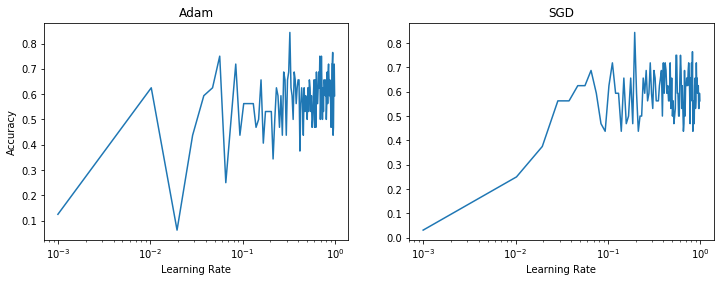

In [52]:
lr_sgd = read_clr_history('lr_range_test-sgd.pkl', '1')
lr_adam = read_clr_history('lr_range_test-adam.pkl', '2')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(lr_adam['lr'], lr_adam['acc'])
ax1.set_xlabel('Learning Rate')
ax1.set_ylabel('Accuracy')
ax1.set_xscale('log')
ax1.set_title('Adam')

ax2.plot(lr_sgd['lr'], lr_sgd['acc'])
ax2.set_xlabel('Learning Rate')
ax2.set_xscale('log')
ax2.set_title('SGD')

plt.savefig('adam-sgd-lrtest.png');

SGD appears to be a more stable system for this system's cost function. 

In [11]:
max_sgd_lr = 0.112
min_sgd_lr = max_sgd_lr * 0.1 # Smith et. al 
max_adam_lr = 0.055
min_adam_lr = max_adam_lr * 0.1 # Smith et. al 
step_size = 108 * 6 # Smith et. al 


adam_clr= CyclicLR(mode='triangular', base_lr=min_adam_lr, max_lr=max_adam_lr,
                          step_size=step_size)
sgd_clr= CyclicLR(mode='triangular', base_lr=min_sgd_lr, max_lr=max_sgd_lr,
                          step_size=step_size)

Running Adam and SGD to see how they compare to their baselines...

In [9]:
lr_optim.build_model(optimizer=optimizers.Adam())

lr_optim.fit(epochs=5, callbacks=[adam_clr])

Epoch 1/5
108/108 [==============================] - 993s 9s/step - loss: 6.4703 - acc: 0.5919 - val_loss: 5.8764 - val_acc: 0.6354
Epoch 2/5
108/108 [==============================] - 1087s 10s/step - loss: 6.5156 - acc: 0.5958 - val_loss: 5.8885 - val_acc: 0.6347
Epoch 3/5
108/108 [==============================] - 1061s 10s/step - loss: 6.5261 - acc: 0.5951 - val_loss: 5.8455 - val_acc: 0.6373
Epoch 4/5
108/108 [==============================] - 1070s 10s/step - loss: 6.5202 - acc: 0.5955 - val_loss: 5.9171 - val_acc: 0.6329
Epoch 5/5
108/108 [==============================] - 1061s 10s/step - loss: 6.5202 - acc: 0.5955 - val_loss: 5.8455 - val_acc: 0.6373


Adam has poor convergence, likely stuck at local minimum in cost function.

In [14]:
reset_keras(lr_optim)

lr_optim.build_model(optimizer=optimizers.SGD())

lr_optim.fit(epochs=5, callbacks=[adam_clr])

8
Epoch 1/5
108/108 [==============================] - 927s 9s/step - loss: 1.0031 - acc: 0.6157 - val_loss: 0.8771 - val_acc: 0.7526
Epoch 2/5
108/108 [==============================] - 861s 8s/step - loss: 0.7604 - acc: 0.7080 - val_loss: 0.6541 - val_acc: 0.7662
Epoch 3/5
108/108 [==============================] - 869s 8s/step - loss: 0.6623 - acc: 0.7441 - val_loss: 0.4952 - val_acc: 0.8516
Epoch 4/5
108/108 [==============================] - 862s 8s/step - loss: 0.5741 - acc: 0.7784 - val_loss: 0.4252 - val_acc: 0.8800
Epoch 5/5
108/108 [==============================] - 861s 8s/step - loss: 0.5017 - acc: 0.8051 - val_loss: 0.4278 - val_acc: 0.8844


Ran SGD optimizer with Adam LR range by mistake... quick convergence. Lucky mistake.

In [12]:
# reset_keras(lr_optim)

lr_optim.build_model(optimizer=optimizers.SGD())

lr_optim.fit(epochs=5, callbacks=[sgd_clr])

Epoch 1/5
107/107 [==============================] - 98s 916ms/step - loss: 0.9758 - acc: 0.6279 - val_loss: 0.8148 - val_acc: 0.7759
Epoch 2/5
107/107 [==============================] - 92s 861ms/step - loss: 0.7992 - acc: 0.6969 - val_loss: 0.8084 - val_acc: 0.7075
Epoch 3/5
107/107 [==============================] - 91s 850ms/step - loss: 0.7501 - acc: 0.7214 - val_loss: 0.6650 - val_acc: 0.8032
Epoch 4/5
107/107 [==============================] - 91s 850ms/step - loss: 0.6941 - acc: 0.7272 - val_loss: 0.6493 - val_acc: 0.8095
Epoch 5/5
107/107 [==============================] - 91s 848ms/step - loss: 0.6678 - acc: 0.7326 - val_loss: 0.6952 - val_acc: 0.7075


SGD optimizer with initial LR range did not perform as well as SGD with Adam LR. Tweaking Adam LR to run on SGD. 

In [15]:
max_sgd_lr = 0.05
min_sgd_lr = max_sgd_lr * 0.3

sgd_clr= CyclicLR(mode='triangular', base_lr=min_sgd_lr, max_lr=max_sgd_lr,
                          step_size=step_size)

In [14]:
reset_keras(lr_optim)

lr_optim.build_model(optimizer=optimizers.SGD())

lr_optim.fit(epochs=5, callbacks=[sgd_clr])

888
Epoch 1/5
108/108 [==============================] - 860s 8s/step - loss: 0.9605 - acc: 0.6350 - val_loss: 0.8865 - val_acc: 0.7604
Epoch 2/5
108/108 [==============================] - 892s 8s/step - loss: 0.7912 - acc: 0.7112 - val_loss: 0.7983 - val_acc: 0.7849
Epoch 3/5
108/108 [==============================] - 876s 8s/step - loss: 0.7542 - acc: 0.7245 - val_loss: 0.9842 - val_acc: 0.7129
Epoch 4/5
108/108 [==============================] - 877s 8s/step - loss: 0.7080 - acc: 0.7329 - val_loss: 0.6869 - val_acc: 0.7849
Epoch 5/5
108/108 [==============================] - 869s 8s/step - loss: 0.6834 - acc: 0.7394 - val_loss: 0.6207 - val_acc: 0.8382


In [15]:
with open(os.path.join(TESTFILES_PATH, 'clr-sgd-min01max05.pkl'), 'wb') as fh:
    pickle.dump(sgd_clr.history, fh)

In [16]:
K.clear_session()

#### Notes:
* Adam: 
    * Optimization is stuck at a local minima, cyclical LR with Adam appears less stable optim system than gradient descent for this dataset.
    * May need a tighter LR range 
    * Still had best performance in initial screen...
* SGD
    * Mistakenly ran SGD with Adam CLR, performance converged quickly
        * May be the best LR
    * Cyclical LR seems to help regularlize model
    * Convergence is very quick

## Momentum
Running LR-test short runs with momenta of :
* 0.99
* 0.97
* 0.95
* 0.9

In [10]:
max_sgd_lr = 1.0
min_sgd_lr = .001
step_size = 108

sgd_clr= CyclicLR(mode='triangular', base_lr=min_sgd_lr, max_lr=max_sgd_lr,
                          step_size=step_size)

In [11]:
momentum_optim = SEMNet(train_df, test_df)
momentum_optim.build_flow_generators(batch_size=32)

C:\Users\MCopeland155816\AppData\Local\Continuum\anaconda3\envs\tf_env\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:269: UserWarning: Found 22 invalid image filename(s) in x_col="image_paths". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 3473 validated image filenames belonging to 4 classes.
Found 1157 validated image filenames belonging to 4 classes.


#### Momentum=0.99 

In [12]:
reset_keras(momentum_optim)

momentum_optim.build_model(optimizer=optimizers.SGD(momentum=0.99))
momentum_optim.fit(epochs=1, callbacks=[sgd_clr])

31
Epoch 1/1
108/108 [==============================] - 870s 8s/step - loss: 1.2120 - acc: 0.5589 - val_loss: 1.0987 - val_acc: 0.6354


In [13]:
with open(os.path.join(TESTFILES_PATH, 'clr-sgd-lrtest-mom99.pkl'), 'wb') as fh:
    pickle.dump(sgd_clr.history, fh)

#### Momentum=0.97

In [14]:
reset_keras(momentum_optim)

sgd_clr= CyclicLR(mode='triangular', base_lr=min_sgd_lr, max_lr=max_sgd_lr,
                          step_size=step_size)

# del momentum_optim.model
momentum_optim.build_model(optimizer=optimizers.SGD(momentum=0.97))
momentum_optim.fit(epochs=1, callbacks=[sgd_clr])

9768
Epoch 1/1
108/108 [==============================] - 841s 8s/step - loss: 4.5518 - acc: 0.5687 - val_loss: 5.8764 - val_acc: 0.6354


In [15]:
with open(os.path.join(TESTFILES_PATH, 'clr-sgd-lrtest-mom97.pkl'), 'wb') as fh:
    pickle.dump(sgd_clr.history, fh)

#### Momentum=0.95

In [16]:
reset_keras(momentum_optim)

sgd_clr= CyclicLR(mode='triangular', base_lr=min_sgd_lr, max_lr=max_sgd_lr,
                          step_size=step_size)


momentum_optim.build_model(optimizer=optimizers.SGD(momentum=0.95))
momentum_optim.fit(epochs=1, callbacks=[sgd_clr])

72315
Epoch 1/1
108/108 [==============================] - 859s 8s/step - loss: 1.1684 - acc: 0.5791 - val_loss: 1.1090 - val_acc: 0.6354


In [17]:
with open(os.path.join(TESTFILES_PATH, 'clr-sgd-lrtest-mom95.pkl'), 'wb') as fh:
    pickle.dump(sgd_clr.history, fh)

#### Momentum=0.9

In [18]:
reset_keras(momentum_optim)

sgd_clr= CyclicLR(mode='triangular', base_lr=min_sgd_lr, max_lr=max_sgd_lr,
                          step_size=step_size)

momentum_optim.build_model(optimizer=optimizers.SGD(momentum=0.9))
momentum_optim.fit(epochs=1, callbacks=[sgd_clr])

76487
Epoch 1/1
108/108 [==============================] - 864s 8s/step - loss: 4.0494 - acc: 0.5803 - val_loss: 5.8764 - val_acc: 0.6354


In [19]:
with open(os.path.join(TESTFILES_PATH, 'clr-sgd-lrtest-mom90.pkl'), 'wb') as fh:
    pickle.dump(sgd_clr.history, fh)

In [11]:
def read_clr_history(filepath, momentum):
    with open(os.path.join(TESTFILES_PATH, filepath), 'rb') as fh:
        df = pd.DataFrame(pickle.load(fh))
        df['momentum'] = [int(momentum)] * len(df)
    return df

In [24]:
mom90 = read_clr_history('clr-sgd-lrtest-mom90.pkl', 90)
mom95 = read_clr_history('clr-sgd-lrtest-mom95.pkl', 95)
mom97 = read_clr_history('clr-sgd-lrtest-mom97.pkl', 97)
mom99 = read_clr_history('clr-sgd-lrtest-mom99.pkl', 99)

momentum_lr = pd.concat([mom90, mom95, mom97, mom99])

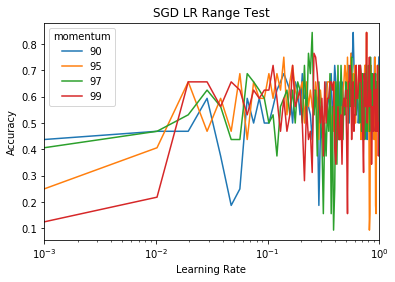

In [37]:
fig, ax = plt.subplots()

momentum_lr.pivot_table(index='lr', columns='momentum', values='acc').plot(ax=ax)
ax.set_xscale('log')
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Accuracy')
ax.set_title('SGD LR Range Test')
plt.savefig('momentum-lr.png')

Want to set momentum as high as possible while remaining stable... 97-99 range seems fine.

## Weight Decay 

In [9]:
wd_optim = SEMNet(train_df, test_df)
wd_optim.build_flow_generators(batch_size=32)

C:\Users\MCopeland155816\AppData\Local\Continuum\anaconda3\envs\tf_env\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:269: UserWarning: Found 22 invalid image filename(s) in x_col="image_paths". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 3473 validated image filenames belonging to 4 classes.
Found 1157 validated image filenames belonging to 4 classes.


In [10]:
max_sgd_lr = 1.0
min_sgd_lr = .001
step_size = 108

sgd_clr= CyclicLR(mode='triangular', base_lr=min_sgd_lr, max_lr=max_sgd_lr,
                          step_size=step_size)

### WD: $10^3$ 

In [11]:
wd_optim.build_model(optimizer=optimizers.SGD(decay=1e-3))
wd_optim.fit(epochs=1, callbacks=[sgd_clr])

Epoch 1/1
108/108 [==============================] - 919s 9s/step - loss: 1.1453 - acc: 0.5811 - val_loss: 1.0360 - val_acc: 0.6354


In [12]:
with open(os.path.join(TESTFILES_PATH, 'clr-sgd-lrtest-wd1e-3.pkl'), 'wb') as fh:
    pickle.dump(sgd_clr.history, fh)

### WD: $10^4$ 

In [13]:
reset_keras(wd_optim)

sgd_clr= CyclicLR(mode='triangular', base_lr=min_sgd_lr, max_lr=max_sgd_lr,
                          step_size=step_size)

wd_optim.build_model(optimizer=optimizers.SGD(decay=1e-4))
wd_optim.fit(epochs=1, callbacks=[sgd_clr])

5550
Epoch 1/1
108/108 [==============================] - 957s 9s/step - loss: 2.5885 - acc: 0.5869 - val_loss: 5.8764 - val_acc: 0.6354


In [14]:
with open(os.path.join(TESTFILES_PATH, 'clr-sgd-lrtest-wd1e-4.pkl'), 'wb') as fh:
    pickle.dump(sgd_clr.history, fh)

### WD: $10^5$ 

In [15]:
reset_keras(wd_optim)

sgd_clr= CyclicLR(mode='triangular', base_lr=min_sgd_lr, max_lr=max_sgd_lr,
                          step_size=step_size)

wd_optim.build_model(optimizer=optimizers.SGD(decay=1e-5))
wd_optim.fit(epochs=1, callbacks=[sgd_clr])

9693
Epoch 1/1
108/108 [==============================] - 1003s 9s/step - loss: 1.1788 - acc: 0.5775 - val_loss: 1.0219 - val_acc: 0.6354


In [16]:
with open(os.path.join(TESTFILES_PATH, 'clr-sgd-lrtest-wd1e-5.pkl'), 'wb') as fh:
    pickle.dump(sgd_clr.history, fh)

### WD: $10^6$ 

In [17]:
reset_keras(wd_optim)

sgd_clr= CyclicLR(mode='triangular', base_lr=min_sgd_lr, max_lr=max_sgd_lr,
                          step_size=step_size)

wd_optim.build_model(optimizer=optimizers.SGD(decay=1e-6))
wd_optim.fit(epochs=1, callbacks=[sgd_clr])

76640
Epoch 1/1
108/108 [==============================] - 992s 9s/step - loss: 1.1758 - acc: 0.5813 - val_loss: 1.0130 - val_acc: 0.6354


In [19]:
with open(os.path.join(TESTFILES_PATH, 'clr-sgd-lrtest-wd1e-6.pkl'), 'wb') as fh:
    pickle.dump(sgd_clr.history, fh)

In [22]:
wd3 = read_clr_history('clr-sgd-lrtest-wd1e-3.pkl', -3)
wd4 = read_clr_history('clr-sgd-lrtest-wd1e-4.pkl', -4)
wd5 = read_clr_history('clr-sgd-lrtest-wd1e-5.pkl', -5)
wd6 = read_clr_history('clr-sgd-lrtest-wd1e-6.pkl', -6)

wd_lr = pd.concat([wd3, wd4, wd5, wd6])

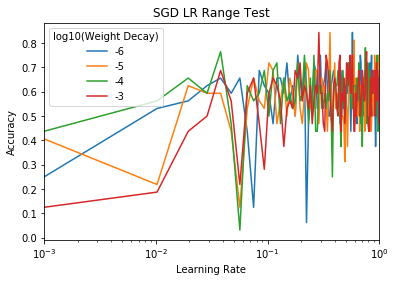

In [23]:
fig, ax = plt.subplots()

wd_lr.pivot_table(index='lr', columns='momentum', values='acc').plot(ax=ax)
ax.set_xscale('log')
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Accuracy')
ax.set_title('SGD LR Range Test')
ax.legend(title='log10(Weight Decay)')
plt.savefig('wd-lr.png')

10e4, 10e6 are best WD

# Test Run

In [13]:
max_sgd_lr = 0.055
min_sgd_lr = max_sgd_lr * 0.1 # Smith et. al 
step_size = 108 * 6 # Smith et. al 
momentum = 0.97
weight_decay = 10e-4

sgd = optimizers.SGD(momentum=momentum, decay=weight_decay)
clr = CyclicLR(mode='triangular', base_lr=min_sgd_lr, max_lr=max_sgd_lr,
                          step_size=step_size)

In [25]:
test1 = SEMNet(train_df, test_df)
test1.build_flow_generators()

Found 3473 validated image filenames belonging to 4 classes.
Found 1157 validated image filenames belonging to 4 classes.


In [ ]:
test1.build_model(optimizer=sgd)
test1.fit(callbacks=[clr], epochs=15)

Epoch 1/15
108/108 [==============================] - 922s 9s/step - loss: 0.9739 - acc: 0.6274 - val_loss: 0.8586 - val_acc: 0.7387
Epoch 2/15
108/108 [==============================] - 964s 9s/step - loss: 0.8730 - acc: 0.6582 - val_loss: 0.7708 - val_acc: 0.7138
Epoch 3/15
108/108 [==============================] - 922s 9s/step - loss: 0.8442 - acc: 0.6698 - val_loss: 0.7273 - val_acc: 0.7467
Epoch 4/15
108/108 [==============================] - 912s 8s/step - loss: 0.8729 - acc: 0.6533 - val_loss: 0.7961 - val_acc: 0.6844
Epoch 5/15
108/108 [==============================] - 988s 9s/step - loss: 0.9575 - acc: 0.6252 - val_loss: 0.7680 - val_acc: 0.7547
Epoch 6/15
108/108 [==============================] - 944s 9s/step - loss: 1.0993 - acc: 0.6039 - val_loss: 1.0366 - val_acc: 0.6373
Epoch 7/15
108/108 [==============================] - 869s 8s/step - loss: 1.1254 - acc: 0.5917 - val_loss: 1.0169 - val_acc: 0.6373
Epoch 8/15
108/108 [==============================] - 903s 8s/step - 

Performs poorly with CLR in training. Trying taking it out.

In [12]:
test2 = SEMNet(train_df, test_df)
test2.build_flow_generators()

C:\Users\MCopeland155816\AppData\Local\Continuum\anaconda3\envs\tf_env\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:269: UserWarning: Found 22 invalid image filename(s) in x_col="image_paths". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 3473 validated image filenames belonging to 4 classes.
Found 1157 validated image filenames belonging to 4 classes.


In [14]:
test2.build_model(optimizer=sgd)
test2.fit(epochs=15)

Epoch 1/15
108/108 [==============================] - 913s 8s/step - loss: 1.0169 - acc: 0.6159 - val_loss: 0.7337 - val_acc: 0.7439
Epoch 2/15
108/108 [==============================] - 1064s 10s/step - loss: 0.8523 - acc: 0.6683 - val_loss: 0.7157 - val_acc: 0.7360
Epoch 3/15
108/108 [==============================] - 938s 9s/step - loss: 0.7523 - acc: 0.7020 - val_loss: 0.5856 - val_acc: 0.8169
Epoch 4/15
108/108 [==============================] - 960s 9s/step - loss: 0.6820 - acc: 0.7406 - val_loss: 0.5426 - val_acc: 0.8222
Epoch 5/15
108/108 [==============================] - 937s 9s/step - loss: 0.6226 - acc: 0.7671 - val_loss: 0.4653 - val_acc: 0.8409
Epoch 6/15
108/108 [==============================] - 1016s 9s/step - loss: 0.5857 - acc: 0.7823 - val_loss: 0.5189 - val_acc: 0.8311
Epoch 7/15
108/108 [==============================] - 898s 8s/step - loss: 0.5721 - acc: 0.7826 - val_loss: 0.4751 - val_acc: 0.8489
Epoch 8/15
108/108 [==============================] - 895s 8s/step

test2 is underfitting... it might need to get taken out to >20 epochs

Next test, try default momentum/decay

In [ ]:
# reset_keras(test2)
# test3 = test2

max_sgd_lr = 0.055
min_sgd_lr = max_sgd_lr * 0.1 # Smith et. al 
step_size = 108 * 6 # Smith et. al 
momentum = 0.99
weight_decay = 10e-6

sgd = optimizers.SGD(lr=max_sgd_lr, momentum=momentum, decay=weight_decay)

test3 = SEMNet(train_df, test_df)
test3.build_flow_generators()
test3.build_model(optimizer=sgd)
test3.fit(epochs=15)

C:\Users\MCopeland155816\AppData\Local\Continuum\anaconda3\envs\tf_env\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:269: UserWarning: Found 22 invalid image filename(s) in x_col="image_paths". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 3473 validated image filenames belonging to 4 classes.
Found 1157 validated image filenames belonging to 4 classes.
Epoch 1/15
108/108 [==============================] - 964s 9s/step - loss: 1.1432 - acc: 0.5901 - val_loss: 1.0050 - val_acc: 0.6354
Epoch 2/15
108/108 [==============================] - 870s 8s/step - loss: 1.1164 - acc: 0.5955 - val_loss: 1.0362 - val_acc: 0.6347
Epoch 3/15
108/108 [==============================] - 862s 8s/step - loss: 1.1324 - acc: 0.5965 - val_loss: 1.0064 - val_acc: 0.6373
Epoch 4/15
108/108 [==============================] - 851s 8s/step - loss: 1.1166 - acc: 0.5951 - val_loss: 1.0509 - val_acc: 0.6302
Epoch 5/15
108/108 [==============================] - 846s 8s/step - loss: 1.8255 - acc: 0.5717 - val_loss: 5.8455 - val_acc: 0.6373
Epoch 6/15
108/108 [==============================] - 830s 8s/step - loss: 6.5406 - acc: 0.5942 - val_loss: 5.7595 - val_acc: 0.6427
Epoch 7/15
107/108 [============================>.] - ETA: 5s - loss: 6.5153 - a

Strange that there's no convergence... LR must be too high...

In [ ]:
momentum = 0.97
weight_decay = 10e-6

sgd = optimizers.SGD(lr=0.01, momentum=momentum, decay=weight_decay)

test4 = SEMNet(train_df, test_df)
test4.build_flow_generators()
test4.build_model(optimizer=sgd)
test4.fit(epochs=10)

C:\Users\MCopeland155816\AppData\Local\Continuum\anaconda3\envs\tf_env\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:269: UserWarning: Found 22 invalid image filename(s) in x_col="image_paths". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 3473 validated image filenames belonging to 4 classes.
Found 1157 validated image filenames belonging to 4 classes.
Epoch 1/10
108/108 [==============================] - 887s 8s/step - loss: 1.0295 - acc: 0.6196 - val_loss: 0.9504 - val_acc: 0.6510
Epoch 2/10
108/108 [==============================] - 986s 9s/step - loss: 0.8102 - acc: 0.6808 - val_loss: 0.6156 - val_acc: 0.8000
Epoch 3/10
108/108 [==============================] - 893s 8s/step - loss: 0.7699 - acc: 0.7033 - val_loss: 0.5921 - val_acc: 0.8267
Epoch 4/10
108/108 [==============================] - 960s 9s/step - loss: 0.6804 - acc: 0.7336 - val_loss: 0.7289 - val_acc: 0.7653
Epoch 5/10
108/108 [==============================] - 848s 8s/step - loss: 0.6336 - acc: 0.7461 - val_loss: 0.4510 - val_acc: 0.8693
Epoch 6/10
108/108 [==============================] - 862s 8s/step - loss: 0.6099 - acc: 0.7514 - val_loss: 0.4755 - val_acc: 0.8249
Epoch 7/10
108/108 [==============================] - 886s 8s/step - loss: 0.589

Moving forward with:
* WD: 10e-4
* momentum: 0.97
* LR: 0.01

## Cosine Annealing 

In [9]:
class SnapshotEnsemble(Callback):

    def __init__(self, n_epochs, n_cycles, lrate_max, verbose=0):
        self.epochs = n_epochs
        self.cycles = n_cycles
        self.lr_max = lrate_max
        self.lrates = list()
 
    def cosine_annealing(self, epoch, n_epochs, n_cycles, lrate_max):
        epochs_per_cycle = np.floor(n_epochs/n_cycles)
        cos_inner = (np.pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
        return lrate_max/2 * (np.cos(cos_inner) + 1)
 
    def on_epoch_begin(self, epoch, logs={}):

        lr = self.cosine_annealing(epoch, self.epochs, self.cycles, self.lr_max)
        K.set_value(self.model.optimizer.lr, lr)
        self.lrates.append(lr)
 
    def on_epoch_end(self, epoch, logs={}):
        epochs_per_cycle = np.floor(self.epochs / self.cycles)
        if epoch != 0 and (epoch + 1) % epochs_per_cycle == 0:
            # save model to file
            filename = "snapshot_model_%d.h5" % int((epoch + 1) / epochs_per_cycle)
            self.model.save(filename)
            print('>saved snapshot %s, epoch %d' % (filename, epoch))

In [12]:
max_sgd_lr = 0.055
min_sgd_lr = max_sgd_lr * 0.1 # Smith et. al 
step_size = 108 * 6 # Smith et. al 
momentum = 0.97
weight_decay = 10e-4

sgd = optimizers.SGD(momentum=momentum, decay=weight_decay)

In [15]:
snap_test = SEMNet(train_df, test_df)
snap_test.build_flow_generators()

C:\Users\MCopeland155816\AppData\Local\Continuum\anaconda3\envs\tf_env\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:269: UserWarning: Found 22 invalid image filename(s) in x_col="image_paths". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 3473 validated image filenames belonging to 4 classes.
Found 1157 validated image filenames belonging to 4 classes.


In [17]:
n_epochs = 80
n_cycles = n_epochs / 10

cos_anneal = SnapshotEnsemble(n_epochs, n_cycles, 0.01)

snap_test.build_model(optimizer=sgd)
snap_test.fit(epochs=80, callbacks = [cos_anneal])

Epoch 1/80
108/108 [==============================] - 1026s 10s/step - loss: 1.0121 - acc: 0.6199 - val_loss: 0.8487 - val_acc: 0.6962
Epoch 2/80
108/108 [==============================] - 1046s 10s/step - loss: 0.8663 - acc: 0.6612 - val_loss: 0.6249 - val_acc: 0.7618
Epoch 3/80
108/108 [==============================] - 1055s 10s/step - loss: 0.7596 - acc: 0.7023 - val_loss: 0.6182 - val_acc: 0.7956
Epoch 4/80
108/108 [==============================] - 1051s 10s/step - loss: 0.6685 - acc: 0.7336 - val_loss: 0.5950 - val_acc: 0.7929
Epoch 5/80
108/108 [==============================] - 1052s 10s/step - loss: 0.6425 - acc: 0.7522 - val_loss: 0.5394 - val_acc: 0.8382
Epoch 6/80
108/108 [==============================] - 1024s 9s/step - loss: 0.5571 - acc: 0.7911 - val_loss: 0.4587 - val_acc: 0.8533
Epoch 7/80
108/108 [==============================] - 997s 9s/step - loss: 0.5039 - acc: 0.8022 - val_loss: 0.4591 - val_acc: 0.8720
Epoch 8/80
108/108 [==============================] - 999s

Cycle length will need to be longer than 10 epochs.

Try training on different image_size's in each cycle

In [54]:
snap_history = snap_test.model.history.history
# with open(os.path.join(TESTFILES_PATH, '80ep-history.pkl'), 'wb') as fh:
#     pickle.dump(snap_history, fh)

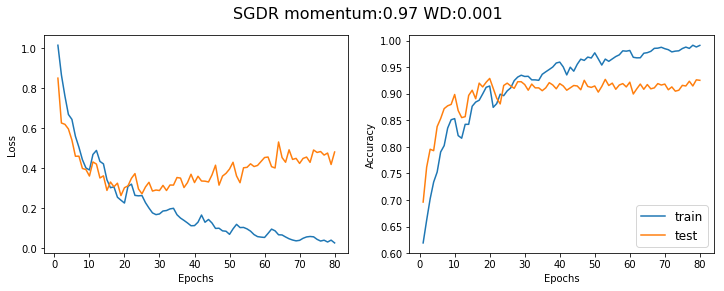

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

epochs = np.arange(1, 81)

ax1.plot(epochs, snap_history['loss'])
ax1.plot(epochs, snap_history['val_loss'])
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epochs')

ax2.plot(epochs, snap_history['acc'], label='train')
ax2.plot(epochs, snap_history['val_acc'], label='test')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epochs')
ax2.legend(prop={'size':12})
plt.suptitle('SGDR momentum:{0} WD:{1}'.format(momentum, weight_decay), size=16)
plt.savefig('80epochs.png');

In [28]:
snap_history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

Changing backend to theano for prediction...

In [10]:
hdtest = SEMNet(train_df, test_df)
hdtest.build_flow_generators()

C:\Users\MCopeland155816\AppData\Local\Continuum\anaconda3\envs\tf_env\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:269: UserWarning: Found 22 invalid image filename(s) in x_col="image_paths". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 3453 validated image filenames belonging to 4 classes.
Found 1150 validated image filenames belonging to 4 classes.


In [13]:
with open(os.path.join(TESTFILES_PATH, 'class_indices.pkl'), 'wb') as fh:
    pickle.dump(hdtest.train_generator.class_indices, fh)

In [17]:
hdtest.build_model(optimizer=optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-6))
hdtest.fit(epochs=50)

Epoch 1/50
107/107 [==============================] - 109s 1s/step - loss: 0.9432 - acc: 0.6437 - val_loss: 0.8225 - val_acc: 0.7500
Epoch 2/50
107/107 [==============================] - 101s 943ms/step - loss: 0.7358 - acc: 0.7217 - val_loss: 0.6265 - val_acc: 0.7621
Epoch 3/50
107/107 [==============================] - 102s 951ms/step - loss: 0.7458 - acc: 0.7202 - val_loss: 0.6662 - val_acc: 0.8175
Epoch 4/50
107/107 [==============================] - 103s 959ms/step - loss: 0.6554 - acc: 0.7350 - val_loss: 0.5187 - val_acc: 0.8336
Epoch 5/50
107/107 [==============================] - 102s 955ms/step - loss: 0.6065 - acc: 0.7547 - val_loss: 0.5189 - val_acc: 0.8318
Epoch 6/50
107/107 [==============================] - 100s 937ms/step - loss: 0.5745 - acc: 0.7651 - val_loss: 0.3979 - val_acc: 0.8667
Epoch 7/50
107/107 [==============================] - 101s 942ms/step - loss: 0.5100 - acc: 0.7855 - val_loss: 0.3909 - val_acc: 0.8623
Epoch 8/50
107/107 [==============================]

Cycle length will need to be longer than 10 epochs.

Try training on different image_size's in each cycle

In [13]:
max_sgd_lr = 0.055
min_sgd_lr = max_sgd_lr * 0.1 # Smith et. al 
step_size = 108 * 6 # Smith et. al 
momentum = 0.97
weight_decay = 10e-4

sgd = optimizers.SGD(momentum=momentum, decay=weight_decay)

### Snap Test 2
LR of 0.05 is too large for cosine annealing with SGD... taking it back down to default 0.01.

In [11]:
snap_test2 = SEMNet(train_df, test_df)
snap_test2.build_flow_generators()

C:\Users\MCopeland155816\AppData\Local\Continuum\anaconda3\envs\tf_env\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:269: UserWarning: Found 22 invalid image filename(s) in x_col="image_paths". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 3453 validated image filenames belonging to 4 classes.
Found 1150 validated image filenames belonging to 4 classes.


In [14]:
n_epochs = 100
n_cycles = n_epochs / 20

cos_anneal = SnapshotEnsemble(n_epochs, n_cycles, 0.01)

snap_test2.build_model(optimizer=sgd)
snap_test2.fit(epochs=n_epochs, callbacks = [cos_anneal])

Epoch 1/100
107/107 [==============================] - 97s 909ms/step - loss: 0.9619 - acc: 0.6308 - val_loss: 0.8421 - val_acc: 0.6536
Epoch 2/100
107/107 [==============================] - 91s 848ms/step - loss: 0.7835 - acc: 0.6908 - val_loss: 0.6230 - val_acc: 0.7612
Epoch 3/100
107/107 [==============================] - 92s 857ms/step - loss: 0.7230 - acc: 0.7202 - val_loss: 0.6218 - val_acc: 0.8077
Epoch 4/100
107/107 [==============================] - 91s 852ms/step - loss: 0.6791 - acc: 0.7425 - val_loss: 0.6780 - val_acc: 0.7612
Epoch 5/100
107/107 [==============================] - 93s 872ms/step - loss: 0.6473 - acc: 0.7468 - val_loss: 0.5857 - val_acc: 0.7835
Epoch 6/100
107/107 [==============================] - 93s 865ms/step - loss: 0.6154 - acc: 0.7610 - val_loss: 0.5574 - val_acc: 0.7710
Epoch 7/100
107/107 [==============================] - 90s 840ms/step - loss: 0.5368 - acc: 0.7815 - val_loss: 0.4223 - val_acc: 0.8578
Epoch 8/100
107/107 [===========================

In [15]:
snap_history = snap_test2.model.history.history
with open(os.path.join(TESTFILES_PATH, '100ep20cyc-history.pkl'), 'wb') as fh:
    pickle.dump(snap_history, fh)

Model topping at ~92%. Moving to test.

In [11]:
with open(os.path.join(TESTFILES_PATH, '100ep20cyc-history.pkl'), 'rb') as fh:
    snap_history = pd.DataFrame(pickle.load(fh))

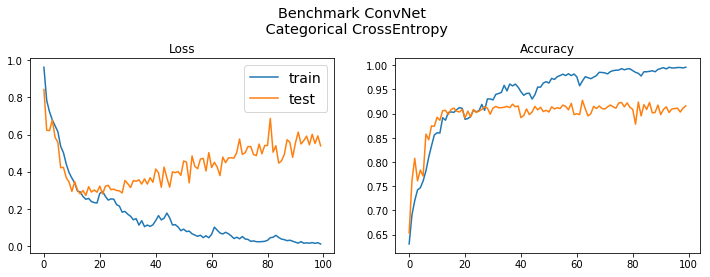

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(snap_history['loss'], label='train')
ax1.plot(snap_history['val_loss'], label='test')
ax1.set_title('Loss')
ax1.legend(prop={'size':'14'})

ax2.plot(snap_history['acc'], label='train')
ax2.plot(snap_history['val_acc'], label='test')
ax2.set_title('Accuracy')

plt.suptitle('Benchmark ConvNet \n Categorical CrossEntropy', size='x-large')
plt.subplots_adjust(top=0.8)
plt.savefig(os.path.join(TESTFILES_PATH, '100ep20cyc.png'));

In [18]:
mask = (snap_history.index + 1) % 20 == 0
snap_history[mask]

,val_loss,val_acc,loss,acc
19,0.290533,0.908766,0.232680,0.910845
39,0.343724,0.915921,0.115556,0.954652
59,0.503645,0.898032,0.045870,0.981877
79,0.541207,0.913238,0.026849,0.992692
99,0.539960,0.915921,0.012624,0.995908


In [22]:
snap_history[snap_history.index > 14].describe()

,val_loss,val_acc,loss,acc
count,85.000000,85.000000,85.000000,85.000000
mean,0.435597,0.909232,0.100368,0.962306
std,0.098913,0.008465,0.079370,0.031111
min,0.273281,0.878354,0.012624,0.888337
25%,0.343724,0.903399,0.037047,0.941830
50%,0.446896,0.910555,0.067518,0.975424
75%,0.503919,0.914132,0.148658,0.986846
max,0.686773,0.927549,0.294646,0.995908
